# Week 11 - Clustering 2 | DBSCAN, HAC, Linkage Methods, Dendrograms

#### <font color='plum'> RESPONSES IN THIS COLOR

For Week 11, include concepts such as:
- density-based spatial clustering of applications with noise (DBSCAN), 
- hierarchical agglomerative clustering (HAC), 
- linkage methods in HAC, and 
- dendrograms.

# Imports

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import kagglehub 
import time
# from sklearn.experimental import enable_halving_search_cv  # Needed to enable

# from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    RepeatedStratifiedKFold, 
    GridSearchCV, 
    # HalvingGridSearchCV,
    RandomizedSearchCV, 
    RepeatedKFold, 
    cross_val_predict, 
    cross_validate, 
    StratifiedKFold, 
    KFold
)

from sklearn.cluster import KMeans, DBSCAN 
# # explicitly require this experimental feature
# from sklearn.experimental import enable_halving_search_cv # noqa
# # now you can import normally from model_selection
# from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    root_mean_squared_error,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score, 
    make_scorer, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    silhouette_score,
    adjusted_rand_score,
    davies_bouldin_score
    
)
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression

from datetime         import datetime, timedelta
from tqdm             import tqdm
from typing import Any, Dict, List, Union, Tuple
from collections import Counter
from scipy.stats import randint
# from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline

from kagglehub              import KaggleDatasetAdapter

sns.set_theme(font_scale=0.8) 
# plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

/Users/arunram/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utility Functions

In [82]:
# globals
random_state    = 42
test_size       = 0.2
n_jobs          = -1
font_size       = 8

In [83]:
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

#### reorder_columns

In [84]:
def reorder_columns(df: pd.DataFrame, col_names: list) -> pd.DataFrame:
    missing_columns = set(col_names) - set(df.columns)
    # if missing_columns:
    #     raise ValueError(f"Missing columns: {missing_columns}")
    
    for col in missing_columns:
        df[col] = np.nan

    df = df[col_names]
    return df

#### null counts

In [85]:
def show_null_counts_features(df: pd.DataFrame) -> pd.DataFrame:
    """
        Identifies and summarizes columns with missing values in given dataframe .

        Steps performed:
            1. Count Null Values: Calculates the total number of null values in each column.
            2. Calculate Null Percentage: Computes the percentage of null values for each column, rounded to two decimal places.
            3. Determine Feature Types: Identifies whether each column is numeric or categorical based on its data type.
            4. Filter and Sort Columns: Filters out columns without missing values and sorts the remaining columns in descending order of their null percentage.
            5. Display Summary: Prints the total number of samples in the dataset. If there are no null values, it informs the user. Otherwise, it prints a table summarizing the columns with missing values, including the feature name, number of null values, null percentage, and feature type.

        Parameters:
            df (pd.DataFrame): The DataFrame to analyze.

        Returns:
            pd.DataFrame: A DataFrame containing the columns with missing values, along with their null counts, null percentages, and feature types.
    """
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:,.2f}%   {row['Type']}")

    return missing_data

#### plot_roc_auc_curve

In [2]:

def plot_roc_auc_curve(classifier, X_test, y_test, title='ROC AUC Curve', ax=None):
    y_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.tight_layout()
    return ax



#### plot_precision_recall_curve

In [3]:


def plot_precision_recall_curve(classifier, X_test, y_test, title='Precision-Recall Curve', ax=None):
    # Get predicted probabilities for the positive class
    y_proba = classifier.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall pairs and average precision score
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Plot the precision-recall curve
    ax.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower left")
    plt.tight_layout()
    
    return ax


#### plot_confusion_matrix

In [4]:

def plot_confusion_matrix(y_true, y_pred, model_name, labels, ax = None):
    font_size = 10
    plt.rcParams.update({"font.size": font_size})
    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax,
                xticklabels=labels, yticklabels=labels)

    # Add TP, TN, FP, FN labels
    height, width = cm.shape
    label_matrix = [["TN", "FP"], ["FN", "TP"]]
    for i in range(height):
        for j in range(width):
            ax.text(j + 0.5, i + 0.7, f"\n{label_matrix[i][j]}", 
                    ha='center', va='center', color='white', fontsize=8, fontweight='bold')

    ax.set_title(f"Confusion Matrix - {model_name}\n {labels}")
    ax.set_xlabel("Predicted", fontsize=font_size)
    ax.set_ylabel("True", fontsize=font_size)
    plt.tight_layout()
    return ax




#### plot_feature_importance

In [5]:

def plot_feature_importance(search, X, title="Feature Importance", color="midnightblue", ax=None):
    """
    Plots a horizontal bar chart of feature importances from the best estimator in a search object,
    sorted in descending order (most important features at the top).

        Parameters:
            - search: A fitted GridSearchCV or RandomizedSearchCV object with a tree-based estimator.
            - X: pandas DataFrame of features used to train the model.
            - title: str, title of the plot.
            - color: str, color of the bars.
            - ax: matplotlib Axes object, optional. If None, a new figure and axes will be created.
    """
    # Get  best model from the search object
    best_model = search.best_estimator_

    # Check if  model has feature_importances_ attribute
    if not hasattr(best_model, "feature_importances_"):
        raise AttributeError("The best estimator does not have 'feature_importances_' attribute.")

    # Extract and sort feature importances
    importances         = best_model.feature_importances_
    sorted_indices      = np.argsort(importances)[::-1]
    sorted_features     = X.columns[sorted_indices]
    sorted_importances  = importances[sorted_indices]

    # Create plot if no Axes object is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.barh(sorted_features, sorted_importances, color=color)
    ax.invert_yaxis()  # Most important features at the top
    ax.set_xlabel("Importance")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


#### plot_metrics

In [6]:
def plot_metrics(param, 
                 parameter_list, 
                 cv_accuracies, 
                 train_accuracies, 
                 test_accuracies, 
                 std_cvs, 
                 best_index, 
                 model_name
                 ):
    """Plots the accuracy and standard deviation metrics."""
    plt.rcParams.update({"font.size": font_size})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 5), sharex=True)
    
    # Use only as many parameter values as computed
    partial_param_list = parameter_list[:len(cv_accuracies)]
    
    # Check if our parameter list is Boolean for proper labeling
    is_boolean      = all(isinstance(val, bool) for val in partial_param_list)
    if is_boolean: 
        # Convert booleans to integer indices for plotting
        x_vals      = list(range(len(partial_param_list)))
        x_labels    = [str(val) for val in partial_param_list]
    else:
        x_vals      = partial_param_list
        x_labels    = partial_param_list
    
    metric = 'Accuracy'

    # ----- First plot: Accuracy ----------------------------------------------------------
    ax1.set_title(f"{model_name} | {metric} vs {param}")
    
    ax1.plot(x_vals, cv_accuracies, marker = '.', label = f"CV {metric}", color = 'midnightblue')
    ax1.plot(x_vals, train_accuracies, marker = '.', label = f"Train {metric}", color = 'green')
    ax1.plot(x_vals, test_accuracies, marker = '.',  label = f"Test {metric}", color = 'orange')
    ax1.scatter([x_vals[best_index]], [cv_accuracies[best_index]], marker='x', s = 100, label = f"Best CV {metric}", color = 'red')
    
    ax1.set_ylabel(metric)
    ax1.legend()
    ax1.grid()
    
    # ----- Second plot: CV Standard Deviation ----------------------------------------------------------
    ax2.set_title(f"{model_name} | CV Standard Deviation vs {param}")
    ax2.plot(x_vals, std_cvs, marker='.', label = f"CV {metric} Std", color = 'midnightblue')
    ax2.set_xlabel(param)
    ax2.set_ylabel("Standard Deviation")
    ax2.legend()
    ax2.grid(alpha = 0.5)
    
    # If using boolean x-values, set custom ticks
    if is_boolean:
        ax2.set_xticks(x_vals)
        ax2.set_xticklabels(x_labels)
    
    plt.tight_layout()
    plt.show()


#### check_early_stopping

In [91]:
def check_early_stopping(mean_cv_accuracy, best_accuracy, no_improve_count, delta, n_iter_no_change):
    """Checks if early stopping criteria are met."""
    if mean_cv_accuracy > best_accuracy + delta:
        best_accuracy = mean_cv_accuracy
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
        print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
        return True, best_accuracy, no_improve_count
    
    return False, best_accuracy, no_improve_count

#### get_parameter_list

In [92]:
def get_parameter_list(parameter: str,  
                       custom_list: list, 
                       df: pd.DataFrame
                       ):
    
    """
    Returns a list of parameter values based on the given parameter name, using a dictionary.

        Args:
            parameter: name of the parameter.
            custom_list: Optional list of custom values, which will override the values in parameter_dict.
            df: Optional DataFrame, used for calculating total features for 'max_features'.

        Returns:
            A list of parameter values.
    """

    parameter_dict = {
        'n_estimators': list(np.arange(50, 1001, 50)),
        'max_samples': [1.0],
        'max_depth': [None] + list(np.arange(2, 17, 2)),
        'bootstrap': [True, False],
        'learning_rate': list(np.arange(.01, .50, .05)),
        'min_samples_size': list(np.arange(1, 11)),
        'min_samples_leaf': list(np.arange(1, 11))
    }

    if custom_list is not None:
        parameter_dict[parameter] = custom_list

    if parameter == 'max_features':
        if df is None:
            raise ValueError("DataFrame 'df' is required to calculate 'max_features'.")
        if parameter_dict.get('max_features') is not None:
            return parameter_dict['max_features']
        else:
            total_features = df.shape[1]
            return list(range(2, total_features)) # or list(range(18, total_features+1)), or any other range you wish.
    
    elif parameter in parameter_dict:
        return parameter_dict[parameter]
    
    else:
        return []
    

#### get_classification_labels

In [93]:
def get_classification_labels(dictionary): 
    """
    Returns the classification labels from a dictionary of outcomes--assumes the values are strings.
    """
    
    return [v for v in dictionary.items()]

#### run_model

In [94]:
# def run_model(
#     model:          Union[BaseEstimator, type],  # The model or model class
#     show_accuracy:  bool,  # score by Accuracy if Classification task else by MSE
#     X_train:        np.ndarray,  # Training feature set
#     y_train:        np.ndarray,  # Training target set
#     X_test:         np.ndarray,  # Testing feature set
#     y_test:         np.ndarray,  # Testing target set
#     n_repeats:      int     = 10,  # Number of repeats for cross-validation
#     cv_folds:       int     = 5,  # Number of k cross-validation folds
#     n_jobs:         int     = -1,  # Number of jobs to run in parallel
#     exp_factor:     float   = 1,  # Exponent factor for MSE values
#     classification_dict     = None,
#     **model_params: Any  # Additional parameters for the model

# ) -> Tuple[float, float, float, float, int, int]:

#     """
#     Runs a machine learning model with specified parameters and performs cross-validation. If task = Classification, plots a confusion matrix.

#         Parameters:
#             - model: The machine learning model or model class to be used.
#             - show_accuracy: Boolean flag to score by accuracy if classification task else by MSE.
#             - X_train: Training feature set as a NumPy array.
#             - y_train: Training target set as a NumPy array.
#             - X_test: Testing feature set as a NumPy array.
#             - y_test: Testing target set as a NumPy array.
#             - n_repeats: Number of repeats for cross-validation (default is 10).
#             - cv_folds: Number of k cross-validation folds (default is 5).
#             - n_jobs: Number of jobs to run in parallel (default is -1).
#             - exp_factor: Exponent factor for MSE values (default is 1).
#             - classification_dict: Dictionary for classification labels (default is None).
#             - **model_params: Additional parameters for the model.

#         Returns:
#             - Tuple containing mean and standard deviation of cross-validation scores, training and testing scores,
#               number of iterations, and number of cross-validation folds.
#     """

#     # Remove extra key used to store error metric, if it was added to the parameter dictionary
#     if 'accuracy_found' in model_params:
#         model_params = model_params.copy()
#         model_params.pop('accuracy_found', None)

#     # Instantiate the model if a class is provided
#     if isinstance(model, type):
#         model = model(**model_params)
#     else:
#         model.set_params(**model_params) # Setting params for an instance

#     decimals = 4 # Number of decimal places to round to
#     # Use RepeatedStratifiedKFold for classification to preserve class distribution
#     # Perform 5-fold cross-validation using accuracy as the scoring metric

#     if show_accuracy:
#         cv_scores = cross_val_score(model,
#                                     X_train,
#                                     y_train,
#                                     scoring = 'accuracy',
#                                     n_jobs  = n_jobs,
#                                     cv      = RepeatedStratifiedKFold(n_splits      = cv_folds,
#                                                                       n_repeats     = n_repeats,
#                                                                       random_state  = 42  # Use a fixed random_state
#                                                                     ),
#                     )

#         mean_cv_accuracy = round(np.mean(cv_scores), decimals)
#         std_cv_accuracy  = round(np.std(cv_scores), decimals)

#         # Fit the model on the full training set
#         model.fit(X_train, y_train)

#         iterations  = n_repeats
#         cv_folds    = cv_folds

#         # Compute training and testing accuracy
#         train_preds     = model.predict(X_train)
#         train_accuracy  = round(accuracy_score(y_train, train_preds), decimals)
#         test_preds      = model.predict(X_test)
#         test_accuracy   = round(accuracy_score(y_test, test_preds), decimals)


#         return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy, iterations, cv_folds

#     else:
#         neg_mse_scores = cross_val_score(model,
#                                      X_train,
#                                      y_train,
#                                      scoring    = 'neg_mean_squared_error',
#                                      cv         = RepeatedKFold(n_splits = 5, n_repeats = n_repeats, random_state = 42),
#                                      n_jobs     = n_jobs
#                                      )

#         mse_scores  = (-neg_mse_scores) ** exp_factor
#         mean_cv_mse = round(np.mean(mse_scores),3)
#         std_cv_mse  = round(np.std(mse_scores), 3)

#         # Fit the model on the full training set
#         model.fit(X_train, y_train)

#         # Compute training MSE and testing MSE
#         train_preds = model.predict(X_train)
#         train_mse   = round(mean_squared_error(y_train, train_preds) ** exp_factor, 3)
#         test_preds  = model.predict(X_test)
#         test_mse    = round(mean_squared_error(y_test, test_preds) ** exp_factor, 3)

#         return mean_cv_mse, std_cv_mse, train_mse, test_mse, iterations, cv_folds


#### sweep_parameter

In [95]:
def sweep_parameter(model,
                    Parameters:     dict,
                    param:          str,
                    parameter_list: list,
                    X_train:        np.ndarray,
                    y_train:        np.ndarray,
                    X_test:         np.ndarray,
                    y_test:         np.ndarray,
                    verbose          = True,
                    show_rmse        = False,
                    show_accuracy    = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10,
                    cv_folds         = 5,
                    classification_dict = None
                    ) -> Dict[str, Any]:

    """
        Sweeps a specified parameter of a Classification machine learning model and evaluates performance metrics.

            Arguments:
                - model:            The machine learning model or model class to be used.
                - Parameters:       Dictionary of model parameters.
                - param:            The parameter to sweep.
                - parameter_list:   List of values to test for the specified parameter.
                - X_train:          Training feature set.
                - y_train:          Training target set.
                - X_test:           Testing feature set.
                - y_test:           Testing target set.
                - verbose:          If True, prints detailed output and plots results (default is True).
                - show_rmse:        If True, shows RMSE instead of MSE (default is True).
                - n_iter_no_change: Number of iterations with no improvement to trigger early stopping (default is None).
                - delta:            Minimum change in MSE to qualify as an improvement (default is 0.001).
                - n_jobs:           Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
                - n_repeats:        Number of repeats for cross-validation (default is 10).
                - cv_folds:         Number of k cross-validation folds (default is 5).
                - classification_dict: Dictionary for classification labels (default is None).

            Returns:
                - Parameters: Updated dictionary of model parameters with the best parameter value found and additional information.
    """

    decimals                = 4
    start                   = time.time()
    Parameters              = Parameters.copy()  # Avoid modifying the original dictionary

    print(f"Running {model.__name__} with {param} sweep...\n")

    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count        = 0
    best_accuracy           = -np.inf  # since higher accuracy is better
    best_test_preds         = None # To store best predictions for confusion matrix

    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc = f"Sweeping {param}"):
        Parameters[param]   = p
        P_temp              = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)

        # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy, iterations, cv_folds = run_model(
            model               = model,
            show_accuracy       = show_accuracy,
            X_train             = X_train,
            y_train             = y_train,
            X_test              = X_test,
            y_test              = y_test,
            n_repeats           = n_repeats,
            cv_folds            = cv_folds,
            n_jobs              = n_jobs,
            exp_factor          = 0.5 if show_rmse else 1,
            classification_dict = classification_dict,
            **P_temp
        )
        print(f"{param} = {p}: CV_mean_accuracy = {mean_cv_accuracy:,.{decimals}f}, Train_accuracy = {train_accuracy:,.{decimals}f}, Test_accuracy = {test_accuracy:,.{decimals}f}")

        cv_accuracies.append(mean_cv_accuracy)
        std_cvs.append(std_cv_accuracy)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

       # Early-stopping logic: maximize accuracy
        if mean_cv_accuracy > best_accuracy + delta:
            best_accuracy       = mean_cv_accuracy
            no_improve_count    = 0

            # Get test predictions for best model
            model_instance      = model(**P_temp) # Instantiate with current best params
            model_instance.fit(X_train, y_train)  # Fit the model with the best parameters
            best_test_preds     = model_instance.predict(X_test)
        else:
            no_improve_count    += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    max_cv_accuracy                 = max(cv_accuracies)
    max_index                       = cv_accuracies.index(max_cv_accuracy)
    best_param                      = parameter_list[max_index]
    
    Parameters['Test_Param']        = param
    Parameters[param]               = best_param
    Parameters['Model']             = model.__name__

    Parameters['Best_CV_Accuracy']  = round(max_cv_accuracy, decimals)
    Parameters['Test_Accuracy']     = round(test_accuracies[max_index], decimals)

    Parameters['n_repeats']         = n_repeats
    Parameters['cv_folds']          = cv_folds

    end                             = time.time()
    execution_time                  = format_hms(end - start)
    Parameters['execution_time']    = execution_time
    timestamp                       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    Parameters['timestamp']         = timestamp

#### GENERATE PLOTS #####
    if verbose:
        plot_metrics(param, parameter_list, cv_accuracies, train_accuracies, test_accuracies, std_cvs, max_index, Parameters['Model'])

        print(f"\nBest {param} found: {best_param}")
        print(f"Best_CV_Accuracy: {max_cv_accuracy:,.{decimals}f}")
        print(f"Test_Accuracy: {round(test_accuracies[max_index], decimals)}")
        
        print("Classification Report:-----------------\n", classification_report(y_test, best_test_preds))
        # Plot CONFUSION MATRIX for best model ############################
        # if show_accuracy and best_test_preds is not None:
        #     fig, ax     = plt.subplots()
            
        #     class_names = get_classification_labels(classification_dict)

        #     plot_confusion_matrix(y_test, best_test_preds, Parameters['Model'], class_names, Parameters['Test_Param'],  ax = ax)
        #     plt.show()

    # Print timestamp and run-time of successful execution
    print(f'Execution time: {execution_time}')
    print("Execute successfully at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end)))

    return Parameters

#### run_GridSearch_RandomizedSearch_CV

In [7]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

def run_GridSearch_RandomizedSearch_CV(
        ensemble_model,
        dataset_name: str,
        parameter_grid: dict,
        X: pd.DataFrame,
        X_train,
        y_train,
        X_test,
        y_test,
        classification_dict: dict,
        CV_tuning_strategy: int = 0,  # 0=Randomized, 1=HalvingGrid, 2=Grid
        is_classifier: bool = True,
        iterations: int = 10,
        n_jobs: int = -1,
        verbose: bool = True,
        n_repeats: int = 10,
        cv_folds: int = 5,
        random_state: int = None,
        scoring_metric: str = 'accuracy',
        halving_factor: int = 2
    ) -> tuple:

    if isinstance(ensemble_model, type):
        model = ensemble_model(random_state=random_state)
    else:
        model = ensemble_model

    model_name = model.__class__.__name__

    search_params = {
        'n_jobs':           n_jobs,
        'verbose':          verbose,
        'cv':               cv_folds,
        'scoring':          scoring_metric,
        'return_train_score': True,
        'random_state':     random_state,
        'estimator':        model
    }

    if CV_tuning_strategy == 0:
        search_type = 'RandomizedSearchCV'

        print(f"Using {search_type}...")
        search = RandomizedSearchCV(
            param_distributions = parameter_grid,
            n_iter              = iterations,
            **search_params
        )

    elif CV_tuning_strategy == 1:
        search_type = 'HalvingGridSearchCV'

        print(f"Using {search_type} with halving factor {halving_factor}...")
        search = HalvingGridSearchCV(
            param_grid          = parameter_grid,
            factor              = halving_factor,
            **search_params
        )

    else:
        if CV_tuning_strategy != 2:
            raise ValueError("CV_tuning_strategy must be 0 (Randomized), 1 (HalvingGrid), or 2 (Grid).")
        search_type = 'GridSearchCV'
        
        print(f"Using {search_type}...")
        search = GridSearchCV(
            param_grid          = parameter_grid,
            **search_params
        )
       

    start   = time.time()
    search.fit(X_train, y_train)
    end     = time.time()

    cv_results_df = pd.DataFrame(search.cv_results_)

    print(f"\nBest Parameters: {search.best_params_}")
    best_score = search.best_score_
    print(f"Best CV Score ({scoring_metric}): {best_score:,.4f}")

    y_pred      = search.best_estimator_.predict(X_test)
    test_score  = accuracy_score(y_test, y_pred, normalize = True)
    print(f"Test Accuracy: {test_score:,.4f}")

    execution_time = format_hms(end - start)
    print(f"Execution Time: {execution_time} seconds")

    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f'Completed at: {timestamp}')

    if is_classifier:
        print(f"\n{model_name} - {search_type}\nClassification Report:\n{classification_report(y_test, y_pred, digits=4)}")

        train_preds     = search.best_estimator_.predict(X_train)
        train_accuracy  = round(accuracy_score(y_train, train_preds), 4)
        print(f"Train Accuracy: {train_accuracy:,.4f}")
        print(f"Test Accuracy: {test_score:,.4f}")

        labels = [v for v in classification_dict.values()] if classification_dict else None
        fig, ax = plt.subplots(2, 2, figsize = (15, 9))
        ax      = ax.flatten()
        # title for the plots
        fig.suptitle(f"{dataset_name}\n{model_name} - {search_type}", fontsize = 12, fontweight='bold')

        plot_roc_auc_curve(search.best_estimator_, X_test, y_test, title = f'{model_name} ROC AUC Curve', ax=ax[0])
        plot_precision_recall_curve(search.best_estimator_, X_test, y_test, title = f'{model_name} Precision-Recall Curve', ax = ax[1])
        plot_confusion_matrix(y_test, y_pred, model_name, labels, ax = ax[2])
        plot_feature_importance(search, X, title = f'{model_name} Feature Importance\n{classification_dict}', color='midnightblue', ax = ax[3])

        plt.tight_layout()
        plt.show()

    best_params_df = pd.DataFrame([search.best_params_])
    best_params_df['Dataset']           = dataset_name
    best_params_df['Model']             = model_name
    best_params_df['Strategy']          = search_type
    best_params_df['Scoring_Metric']    = scoring_metric
    best_params_df['Best_CV_Score']     = best_score
    best_params_df['Test_Accuracy']     = test_score
    best_params_df['execution_time']    = execution_time
    best_params_df['timestamp']         = timestamp

    return best_params_df, cv_results_df, search


### plot_wcss_silhouette

In [8]:
def plot_kmeans_wcss_silhouette(X: pd.DataFrame, 
                                 max_clusters: int = 10, 
                                 random_state: int = 42
                                 ) -> None:
    """
    Plots the Elbow Method (WCSS) and Silhouette Scores for KMeans clustering.

        Parameters:
            - X: pandas DataFrame of features to cluster.
            - max_clusters: Maximum number of clusters to evaluate (default is 10).
            - random_state: Random state for reproducibility (default is 42).   
    """

# WCSS = Within-Cluster Sum of Squares, which measures how compact the clusters are.
# Lower WCSS means points are closer to their cluster centroid.


# n_clusters=i: tries k from 1 to 10.
# init='k-means++': smart initialization to speed up convergence.
# kmeans.inertia_: the WCSS for that k value. 
# The “elbow” point (where WCSS stops decreasing sharply) suggests the best k.   
    wcss = {}
    silhouette_scores = {}
    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_state)
        kmeans.fit(X)
        
        wcss[i]              = kmeans.inertia_
        silhouette_scores[i] = silhouette_score(X, kmeans.labels_)

    # Plotting
    fig, ax1 = plt.subplots()

    color_wcss  = 'tab:green'
    color_sil   = 'tab:red'

    ax1.set_xlabel("Number of Clusters")
    ax1.set_ylabel("WCSS", color = color_wcss)
    ax1.plot(wcss.keys(), wcss.values(), 'gs-', label='WCSS')
    ax1.tick_params(axis='y', labelcolor=color_wcss)

    ax2 = ax1.twinx()
    ax2.set_ylabel("Silhouette Score", color = color_sil)
    ax2.plot(silhouette_scores.keys(), silhouette_scores.values(), 'ro-', label='Silhouette Score')
    ax2.tick_params(axis='y', labelcolor=color_sil)

    fig.tight_layout()
    plt.title('Elbow Method and Silhouette Scores')
    plt.show()

### prepare_data

In [9]:
def prepare_data(
    df: pd.DataFrame,
    target_col: str,
    test_size: float    = 0.2,
    random_state: int   = 42
) -> tuple:
        """
            Prepares a clean DataFrame for modeling by separating features and target, 
            performing an 80/20 train-test split, and scaling numeric features.

            Parameters
            ----------
            df : pd.DataFrame
                The input DataFrame containing features and the target variable.
            target_col : str
                The name of the target column in the DataFrame.
            test_size : float, default=0.2
                The proportion of the dataset to include in the test split.
            random_state : int, default=42
                Random seed for reproducibility.

            Returns
            -------
            tuple
                A tuple containing the following elements:
                - X_train: pd.DataFrame
                    The training features.
                - X_test: pd.DataFrame
                    The testing features.
                - y_train: pd.Series
                    The training target variable.
                - y_test: pd.Series
                    The testing target variable.
        """

        # Encode the target variable

        le                = LabelEncoder()
        df[target_col] = le.fit_transform(df[target_col])
        target_labels     = [str(label) for label in le.classes_] # FIX: Ensure target_labels are strings for classification_report
        print(f"Target variable '{target_col}' encoded successfully.")

        # DROP ROWS WITH MISSING VALUES (The simplest form of imputation)
        df_clean      = df.dropna()
        initial_rows  = df.shape[0]
        final_rows    = df_clean.shape[0]
        print(f"Dropped rows with NaNs. Initial rows: {initial_rows}, Final rows: {final_rows}")
        print(f"Percentage of data retained: {final_rows / initial_rows * 100:.2f}%\n")
        df = df_clean.copy()

        # --- 1. Feature and Target Separation ---
        X_df          = df.drop(columns = [target_col])
        y             = df[target_col]

        for col in df.columns:
            if col != target_col: 
                # Errors='coerce' converts non-numeric text into NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')
        print("Applied robust data type coercion to feature columns.")

         # features for manual scaling
        all_features  = X_df.columns.tolist()

        # --- 2. Data Splitting (80/20) ---
        X_train, X_test, y_train, y_test = train_test_split(
            X_df, y, test_size = test_size, random_state = random_state, stratify = y
        )
        print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}\n")


        # --- 3. Manual Feature Scaling ---
        print("--- Manual Feature Scaling ---")

        scaler          = StandardScaler()
        X_train_scaled  = scaler.fit_transform(X_train) # Fit and transform the training data
        X_test_scaled   = scaler.transform(X_test)   # Transform the test data

        # Convert back to DataFrames for consistency with plotting helpers
        X_train_final   = pd.DataFrame(X_train_scaled, columns=all_features)
        X_test_final    = pd.DataFrame(X_test_scaled, columns=all_features)

        print("Scaling Complete.\n")

        return X_train_final, X_test_final, y_train, y_test, X_df

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

## <font color='plum'> 3.a. Diabetes Health Indicators Dataset
Over 250,000 responses from a U.S. national health survey with demographic and lifestyle variables (e.g., BMI, activity level, smoking, sleep, general health).

Designed for predicting diabetes status (none, pre-diabetic, diabetic).
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

### Load & Clean

In [99]:
file_path = "alexteboul/diabetes-health-indicators-dataset"
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

#diabetes_012_health_indicators_BRFSS2015.csv
#diabetes_binary_health_indicators_BRFSS2015.csv

# Load the latest version
df_3a = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)
df_3a.columns = df_3a.columns.str.strip() 
# df_3a.head(n = 10)

In [100]:

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler


TEST_SIZE      = 0.2

target_col  = 'Diabetes_binary'
X           = df_3a.drop(columns = [target_col]) 
y           = df_3a[target_col] 

print(f'X.shape: {X.shape}, y.shape: {y.shape}\n')
numeric_cols        = []
categorical_cols    = [] # These are binary (0/1) based on the user's definition

# Use column names from X directly
feature_cols = X.columns.tolist()

for col in feature_cols:
   
    # Columns with <= 2 unique values are considered binary/categorical and will be passed through.
    if df_3a[col].nunique() > 2: # type: ignore
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

dict_outcome = {
    0: 'No Diabetes',
    1: 'Pre-/Diabetes'
}

print("\n--- Feature Classification Summary ---")
print(f"Total Features: {len(feature_cols)}")
print(f"Numeric Features (to be scaled): {numeric_cols}")
print(f"Binary/Categorical Features (to be passed through): {categorical_cols}\n")


scaler              = MinMaxScaler()

X_numeric_scaled    = scaler.fit_transform(X[numeric_cols])

# Convert back to DataFrames
X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, 
                                   columns = numeric_cols, 
                                   index = X.index
                                   )


# Combine scaled numeric features with unscaled categorical/binary features
X_final_df          = pd.concat([X_numeric_scaled_df, X[categorical_cols]], axis = 1)

print(f"Final feature matrix shape after scaling and combining: {X_final_df.shape}")
print("--- Scaling Complete ---\n")

print("--- Data Preparation Complete ---\n")

X.shape: (70692, 21), y.shape: (70692,)


--- Feature Classification Summary ---
Total Features: 21
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

Final feature matrix shape after scaling and combining: (70692, 21)
--- Scaling Complete ---

--- Data Preparation Complete ---



### DB-SCAN

In [101]:

# 4. Determine k (min_samples). Features D=21. Use k = 2 * D = 42
k = 42
print(f"Using k = min_samples = {k} for k-distance calculation.")

# 5. Calculate the distance to the k-th nearest neighbor
# n_neighbors is k + 1 because the distance to itself is 0 (the first neighbor)
nn = NearestNeighbors(n_neighbors = k+1, metric = 'euclidean')
nn.fit(X_final_df)

# Get the distances and indices
k_distances, indices    = nn.kneighbors(X_final_df)
# 6. Sort the distances
k_distances_sorted      = np.sort(k_distances[:, k], axis = 0)

Using k = min_samples = 42 for k-distance calculation.


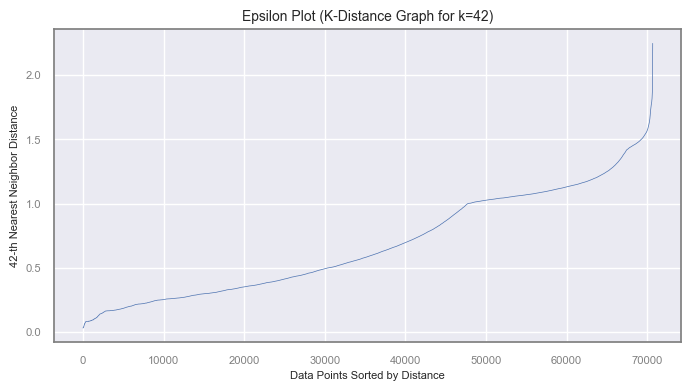

Epsilon plot displayed.
First 10 sorted k-distances for reference:
[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333]

Last 10 sorted k-distances for reference:
[2.0180796  2.03797077 2.04957504 2.05971134 2.06789483 2.09343491
 2.10289071 2.10471141 2.13487455 2.24778446]


In [102]:
# 7. Plot the Epsilon Plot
plt.figure(figsize=(7, 4))
plt.plot(k_distances_sorted)
plt.title(f'Epsilon Plot (K-Distance Graph for k={k})')
plt.xlabel('Data Points Sorted by Distance')


plt.ylabel(f'{k}-th Nearest Neighbor Distance')
# plt.grid(True)
plt.tight_layout()
plt.show()

print("Epsilon plot displayed.")
print("First 10 sorted k-distances for reference:")
print(k_distances_sorted[:10])
print("\nLast 10 sorted k-distances for reference:")
print(k_distances_sorted[-10:])

In [182]:
# --- 2. Fit DBSCAN with Tuned Parameters ---

epsilon         = 1.02  # From visual inspection of the k-distance plot
minimum_samples = 42  # As determined earlier
print(f"Fitting DBSCAN with eps={epsilon} and min_samples={minimum_samples}...")
db      = DBSCAN(eps = epsilon, min_samples = minimum_samples).fit(X_final_df)
labels  = db.labels_

#  number of clusters and noise points
unique_labels   = set(labels)
n_clusters      = len(unique_labels) - (1 if -1 in labels else 0)
n_noise         = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise} ({(n_noise/len(labels))*100:.2f}%)")

Fitting DBSCAN with eps=1.02 and min_samples=42...
Estimated number of clusters: 6
Estimated number of noise points: 11566 (16.36%)


In [177]:
# --- 3. Intrinsic Metric Calculation ---
# Filter out noise points for metrics calculation
from sklearn.metrics import davies_bouldin_score

silhouette_avg  = silhouette_score(X_final_df, labels)
db_score        = davies_bouldin_score(X_final_df, labels)
print(f"-> **Davies-Bouldin Index**: {db_score:.4f} (Lower is better, score < 1 is good clustering)")
print(f"-> **Silhouette Score**: {silhouette_avg:.4f} (Higher is better, score > 0 is good separation)")

-> **Davies-Bouldin Index**: 2.1840 (Lower is better, score < 1 is good clustering)
-> **Silhouette Score**: -0.0280 (Higher is better, score > 0 is good separation)


In [185]:
# --- 3. Cluster Profiling ---
# Add the DBSCAN cluster labels to the original, unscaled DataFrame
df_clustered = df_3a.copy()
df_clustered['Cluster'] = labels

# Calculate the mean of all original features for each cluster
cluster_profiles = df_clustered.groupby('Cluster').mean()

# Rename the noise cluster (-1) for clearer output
cluster_profiles.rename(index={-1: 'Noise'}, inplace=True)

# Select and round key profiling columns for display
key_cols = ['Age', 'BMI', 'GenHlth', 'HighBP', 'HighChol', 'Diabetes_binary']
profile_display = cluster_profiles[key_cols].round(2)

print(f"\n--- Cluster Profiles (Mean of Original Features) ---\n{profile_display}")


--- Cluster Profiles (Mean of Original Features) ---
          Age    BMI  GenHlth  HighBP  HighChol  Diabetes_binary
Cluster                                                         
Noise    8.55  31.36     3.64    0.61      0.56             0.63
0        8.59  29.55     2.68    0.55      0.52             0.47
1        9.20  33.93     3.67    0.00      0.00             0.57
2        9.22  32.07     4.07    1.00      1.00             0.81
3        8.38  34.94     4.09    1.00      1.00             0.88
4        7.72  32.68     3.88    0.00      0.00             0.60
5        9.61  29.12     4.24    1.00      0.00             0.70


### PCA

In [181]:
# --- 4. Apply PCA for Visualization ---
pca                     = PCA(n_components=2)
principal_components    = pca.fit_transform(X_final_df)
pca_df                  = pd.DataFrame(data = principal_components, columns = ['PC 1', 'PC 2'])
pca_df['Cluster']       = labels

explained_variance_pc1_pc2 = pca.explained_variance_ratio_.sum()
explained_variance_pc1 = pca.explained_variance_ratio_[0]
explained_variance_pc2 = pca.explained_variance_ratio_[1]

print(f'Explained variance by PC 1: {explained_variance_pc1:.4f}')
print(f'Explained variance by PC 2: {explained_variance_pc2:.4f}')
print(f'Total explained variance by PC 1 and PC 2: {explained_variance_pc1_pc2:.4f}\n')

Explained variance by PC 1: 0.1897
Explained variance by PC 2: 0.1104
Total explained variance by PC 1 and PC 2: 0.3001



/var/folders/z_/3w4wn_0x6c36h1pzzf2nkpj40000gn/T/ipykernel_7534/2344129088.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  col     = plt.cm.get_cmap('tab10', n_clusters)(k)


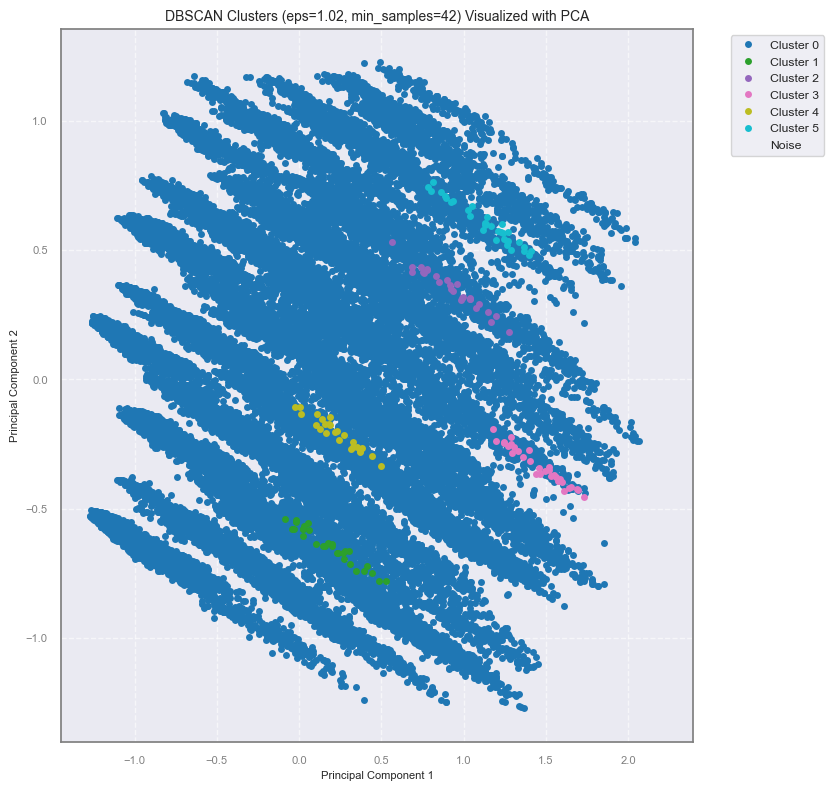

In [166]:
# --- 5. PCA Visualization ---
plt.figure(figsize = (10, 8))
plt.title(f'DBSCAN Clusters (eps={epsilon}, min_samples={minimum_samples}) Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

for k in unique_labels:
    # Ensure correct color mapping
    if k == -1:
        col = 'k' # Black for noise
        marker = 'x'
    else:
        # Use a colormap for distinct clusters (up to 6)
        col     = plt.cm.get_cmap('tab10', n_clusters)(k) 
        marker  = 'o'

    class_member_mask = (labels == k)
    
    xy = pca_df[class_member_mask]
    if not xy.empty:
        plt.plot(xy['PC 1'], xy['PC 2'], marker, markerfacecolor=col,
                 markeredgecolor='none', markersize=5 if k != -1 else 3,
                 label=f'Cluster {k}' if k != -1 else 'Noise')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


## DBSCAN Cluster Profiles ($\epsilon=1.02, \text{min\_samples}=42$)

Mean value of key features for each of the 6 identified clusters and the Noise group.

| Cluster | Mean Age (1-13) | Mean BMI | Mean GenHlth (1-5) | Proportion HighBP | Proportion HighChol | Proportion Diabetes |
|:----------|:---|:---|:---|:---|:---|:---|
| **Noise** | 8.55 | 31.36 | 3.64 | 0.61 | 0.56 | 0.63 |
| **0** | 8.59 | **29.55** | **2.68** | 0.55 | 0.52 | **0.47** |
| **1** | 9.20 | 33.93 | 3.67 | **0.00** | **0.00** | 0.57 |
| **2** | 9.22 | 32.07 | 4.07 | **1.00** | **1.00** | **0.81** |
| **3** | 8.38 | **34.94** | 4.09 | **1.00** | **1.00** | **0.88** |
| **4** | 7.72 | 32.68 | 3.88 | **0.00** | **0.00** | 0.60 |
| **5** | **9.61** | 29.12 | **4.24** | **1.00** | **0.00** | 0.70 |

---

## Cluster Descriptions based on mean values of original features

* **Cluster 0 (Lowest Risk/Healthiest):** This cluster represents the healthiest group. They have the **lowest average BMI**, the **best perceived general health** (lowest `GenHlth` mean), and the **lowest proportion of individuals with diabetes** ($\mathbf{47\%}$).

* **Cluster 3 (Highest Risk Profile):** This cluster is defined by the **highest disease burden**. They have the **highest proportion of diabetes** ($\mathbf{88\%}$), the **highest BMI**, and $\mathbf{100\%}$ of individuals in this group have both High Blood Pressure and High Cholesterol.

* **Cluster 2 (High Risk, Full Comorbidities):** This cluster is similar to Cluster 3 but with slightly lower BMI. It is characterized by high diabetes prevalence ($\mathbf{81\%}$), very poor perceived health, and **$100\%$ prevalence** of both HighBP and HighChol.

* **Cluster 1 & 4 (No Comorbidities):** These two clusters are strongly defined by having **$0\%$** High Blood Pressure and High Cholesterol. Cluster 4 is the younger group with a lower mean age ($\mathbf{7.72}$), while Cluster 1 is older ($\mathbf{9.20}$) with a higher BMI.

* **Cluster 5 (Unique Comorbidity Profile):** This cluster is distinct because $\mathbf{100\%}$ of its members have High Blood Pressure, but **$0\%$** have High Cholesterol. It is also the oldest group on average ($\mathbf{9.61}$) with the poorest perceived general health ($\mathbf{4.24}$).

* **Noise (-1):** This group consists of data points that did not meet the density criteria to be assigned to any core cluster. Their profile is a mix, falling near the average of the entire dataset.

---------------

##  <font color='plum'> 3.b. Hypertension Risk Prediction Dataset

Includes lifestyle, demographic, and clinical data (e.g., BMI, cholesterol, stress,
salt intake, smoking, family history) from individuals across multiple countries. It is
labeled for classification tasks (low vs. high risk of hypertension).
https://www.kaggle.com/datasets/ankushpanday1/hypertension-risk-prediction-dataset

### Load & Clean

In [19]:

file_path = "ankushpanday1/hypertension-risk-prediction-dataset"
file_name = "hypertension_dataset.csv"

df_3b = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)
df_3b.columns = df_3b.columns.str.strip() 
print(df_3b.shape)
df_3b.head()

(174982, 23)


,Country,Age,BMI,Cholesterol,Systolic_BP,Diastolic_BP,Smoking_Status,Alcohol_Intake,Physical_Activity_Level,Family_History,...,Sleep_Duration,Heart_Rate,LDL,HDL,Triglycerides,Glucose,Gender,Education_Level,Employment_Status,Hypertension
0,UK,58,29.5,230,160,79,Never,27.9,Low,Yes,...,6.1,80,100,75,72,179,Female,Primary,Unemployed,High
1,Spain,34,36.2,201,120,84,Never,27.5,High,Yes,...,9.8,56,77,47,90,113,Male,Secondary,Unemployed,High
2,Indonesia,73,18.2,173,156,60,Current,1.8,High,Yes,...,5.2,75,162,56,81,101,Male,Primary,Employed,Low
3,Canada,60,20.3,183,122,94,Never,11.6,Moderate,Yes,...,7.5,71,164,93,94,199,Female,Secondary,Retired,High
4,France,73,21.8,296,91,97,Never,29.1,Moderate,Yes,...,5.0,52,108,74,226,157,Female,Primary,Employed,High


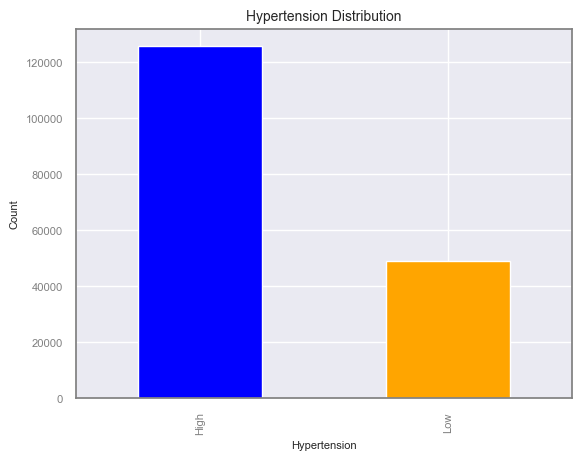

In [20]:
# pandas plot of 'Hypertension' column
df_3b['Hypertension'].value_counts().plot(kind='bar', title='Hypertension Distribution', xlabel='Hypertension', ylabel='Count', color=['blue', 'orange'])
plt.show()

<font color='plum'>

- This is an extremely imbalanced dataset, which isn't helping matters. The model will always favor the majority class to optimize accuracy at expense of minority class

- Will explore 'f1' or 'recall' in RandomizedSearchCV to force the model to optimize for minority class performance.


In [21]:
target_col          = 'Hypertension'
categorical_cols    = ['Country', 'Smoking_Status', 'Physical_Activity_Level', 'Family_History', 'Diabetes', 'Gender', 'Education_Level', 'Employment_Status', 'Hypertension']
numeric_cols        = ['Age', 'BMI', 'Cholesterol', 'Systolic_BP', 'Diastolic_BP', 'Alcohol_Intake', 'Stress_Level', 'Salt_Intake', 'Sleep_Duration', 'Heart_Rate', 'LDL', 'HDL', 'Triglycerides', 'Glucose']
len(categorical_cols), len(numeric_cols)

# for col in categorical_cols:
#     print(f'{col}: {df_3b[col].unique()},\n{df_3b[col].nunique()} unique values\n')

(9, 14)

In [22]:
data = df_3b.copy()

# Dropping 'Country' column because it's fucking pointless for this analysis 
data = data.drop(columns = ['Country'])

# One-hot encode 'Smoking_Status', and 'Employment_Status' columns
data = pd.get_dummies(data, columns = ['Smoking_Status', 'Employment_Status'], drop_first = True)

cat_cols_2 = ['Physical_Activity_Level', 'Family_History', 'Diabetes', 'Gender', 'Education_Level']

for col in cat_cols_2:
    data[col] = LabelEncoder().fit_transform(data[col])

# for target column, map 'High' to 1, 'Low' to 0
data[target_col] = data[target_col].map({'High': 1, 'Low': 0})
data.head()

#export data to csv
# data.to_csv('hypertension_dataset_processed.csv', index=False)


,Age,BMI,Cholesterol,Systolic_BP,Diastolic_BP,Alcohol_Intake,Physical_Activity_Level,Family_History,Diabetes,Stress_Level,...,HDL,Triglycerides,Glucose,Gender,Education_Level,Hypertension,Smoking_Status_Former,Smoking_Status_Never,Employment_Status_Retired,Employment_Status_Unemployed
0,58,29.5,230,160,79,27.9,1,1,1,9,...,75,72,179,0,0,1,False,True,False,True
1,34,36.2,201,120,84,27.5,0,1,1,6,...,47,90,113,1,1,1,False,True,False,True
2,73,18.2,173,156,60,1.8,0,1,1,5,...,56,81,101,1,0,0,False,False,False,False
3,60,20.3,183,122,94,11.6,2,1,1,6,...,93,94,199,0,1,1,False,True,True,False
4,73,21.8,296,91,97,29.1,2,1,0,6,...,74,226,157,0,0,1,False,True,False,False


In [23]:
random_state        = 42
test_size           = 0.2

y = data[target_col]
X = data.drop(columns = [target_col])

---

## <font color='plum'> 3.c. Chronic Kidney Disease Dataset

Contains comprehensive data for 1,659 patients, including 54 variables spanning medical history, lab results, medication usage, quality of life, and environmental
exposure. Ideal for regression, classification, and clustering analyses.
https://www.kaggle.com/datasets/rabieelkharoua/chronic-kidney-disease-dataset-analysis

### Load & Clean - CKD

In [68]:
# file_path = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
# file_name = "Chronic_Kidney_Dsease_data.csv"

# # Load the latest version
# df_3c = kagglehub.dataset_load(
#   KaggleDatasetAdapter.PANDAS,
#   file_path,
#   file_name,
# )

# # df_3c.head()
# df_3c.columns       = df_3c.columns.str.strip()
# columns_to_drop     = ['PatientID', 'DoctorInCharge']  # Columns to drop
# df_3c.drop(columns  = columns_to_drop, inplace = True, errors = 'ignore')  # Drop specified columns
# target_col          = 'Diagnosis'
# categorical_cols    = []
# numeric_cols        = []


# X_df = df_3c.drop(columns = [target_col])
# for col in X_df:
#     if len(X_df[col].unique()) < 5:
#         categorical_cols.append(col);
#     else:
#         numeric_cols.append(col);
#     # print(f'{col}: {X_df[col].nunique()} unique values\n')

# print(f"Categorical columns: {categorical_cols}")
# print(f"Numeric columns: {numeric_cols}")
# print(f'# Categorical cols: {len(categorical_cols)}, # Numeric cols: {len(numeric_cols)}')

# categorical_cols_nominal = ['Ethnicity','SocioeconomicStatus', 'EducationLevel']



In [ ]:
file_path  = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
file_name  = "Chronic_Kidney_Dsease_data.csv"
dataset_3c = 'Chronic Kidney Disease Prediction'

# Load latest version
df_3c = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)

df_3c.columns       = df_3c.columns.str.strip()
columns_to_drop     = ['PatientID', 'DoctorInCharge']
df_3c.drop(columns  = columns_to_drop, inplace = True, errors = 'ignore')

# for stupid confusion matrix plot
classification_dict_CKD = {
    0: 'No CKD',
    1: 'CKD'
}

X_train_CKD, X_test_CKD, y_train_CKD, y_test_CKD, X_CKD = prepare_data(
    df              = df_3c,
    target_col      = 'Diagnosis',
    test_size       = test_size,
    random_state    = random_state
)


print("X_train:", X_train_CKD.shape)
print("y_train:", y_train_CKD.shape)
print("X_test:", X_test_CKD.shape)
print("y_test:", y_test_CKD.shape)


Target variable 'Diagnosis' encoded successfully.
Dropped rows with NaNs. Initial rows: 1659, Final rows: 1659
Percentage of data retained: 100.00%

Applied robust data type coercion to feature columns.
Data Split: Training set size = 1327, Test set size = 332

--- Manual Feature Scaling ---
Scaling Complete.

X_train: (1327, 51)
y_train: (1327,)
X_test: (332, 51)
y_test: (332,)


### DB-SCAN

### PCA

# Notes


### <font color='plum'><i>How do the choices of `ϵ` and `MinPts` in `DBSCAN` affect the number and shape of clusters — and what might go wrong if these values are poorly chosen? </i> 

**Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**

DBSCAN is a powerful clustering algorithm that not only groups similar points together but also detects outliers.

- example: A city planner could use DBSCAN to identify clusters of traffic accidents across a city to determine high-risk areas while filtering out isolated incidents as noise. This helps in targeting specific locations for safety improvements such as better signage or traffic-calming measures. 

Unlike K-means, which assumes clusters are nicely shaped like spheres, DBSCAN can discover *clusters of any shape*—even oddly shaped ones like spirals or rings. It does this by looking for dense regions of points separated by areas of lower density. With DBSCAN, unlike K-means, it is not necessary to select a specific number of clusters. 

DBSCAN is controlled by two key parameters: 

- `ϵ (epsilon)`: This defines the neighborhood radius. Two points are considered neighbors if they are no more than ϵ units apart. Choosing an ϵ  that is too small or too large causes problems. 
    * A small ϵ  creates tight neighborhoods, often labeling many points as noise. 
    * A large ϵ can lump distant points together, possibly merging everything into a single massive cluster. 


- `MinPts`: the minimum number of points (including the point itself) required to be within an ϵ -radius neighborhood for a point to be considered a core point. 


Based on `ϵ`  and `MinPts`, DBSCAN classifies points into three categories: 

1. Core points: These have at least MinPts neighbors within their ﻿ϵ﻿-radius. They are at the heart of a dense region. 

2. Border points: These are close to core points (within ﻿ϵ﻿) but don’t have enough neighbors within their own ϵ -radius to be core points themselves. 

3. Noise points: These don’t belong to any cluster. They’re too isolated to be considered part of a dense region. This makes the algorithm robust to outliers.


To be more precise, a dense region is a connected group of epsilon-neighborhoods of core points. Each core point in the region is within ﻿ϵ﻿ of another, and the core points are all linked together in this sense. A cluster is a maximal dense region (the largest possible dense region, including all core points that can be linked to it). 

**What Is a Cluster?**
A cluster in DBSCAN is a connected group of core points, each reachable from another by stepping from one core point to the next within ﻿ϵ﻿. Border points that are directly reachable from core points are included, too. This structure allows DBSCAN to find complex, non-convex shapes that other algorithms miss. 


#### **1. Role of ϵ (Neighborhood Radius)**
*   **Small ϵ**:
    *   Only very close points are considered neighbors.
    *   Leads to **many small clusters** or even labeling most points as noise.
*   **Large ϵ**:
    *   Points far apart are considered neighbors.
    *   Clusters can **merge into large, less meaningful clusters**.
    *   Risk of losing fine-grained structure.

#### **2. Role of MinPts**
*   **Low MinPts (e.g., 2 or 3)**:
    *   Even sparse regions can form clusters.
    *   Increases risk of **false clusters** (clusters formed from random noise).
*   **High MinPts**:
    *   Requires dense regions to form clusters.
    *   Sparse clusters may be labeled as noise.
    *   Works better for large datasets with well-defined dense clusters.

#### **3. Combined Effect**
*   **ϵ too small + MinPts too high**:
    *   Almost everything becomes noise.
*   **ϵ too large + MinPts too low**:
    *   Almost everything becomes one big cluster.
*   **Balanced choice**:
    *   Depends on data scale and density distribution.

#### **4. What Can Go Wrong?**

*   **Incorrect scale**: If features aren’t normalized, ϵ may not make sense.
*   **Varying density**: DBSCAN struggles when clusters have different densities because a single ϵ cannot fit all.
*   **Noise misclassification**: Poor parameter choice can mislabel actual clusters as noise or merge distinct clusters.


✅ **Tip**: Use a **k-distance plot** (plot sorted distances to the k-th nearest neighbor) to estimate a good `ϵ`. Typically, `MinPts ≈ dimensionality + 1` is a starting point.



-------------

### <font color='plum'><i>Why might different linkage methods in HAC (like single vs. complete linkage) lead to very different clustering results, even when starting from the same data? </i>

#### **1. How Linkage Methods Work**

*   **Single Linkage**: Distance between two clusters = **minimum** distance between any pair of points (one from each cluster).
    *   Tends to create **long, chain-like clusters** because it only needs one close pair to merge clusters.
    *   Sensitive to noise and outliers.
*   **Complete Linkage**: Distance = **maximum** distance between any pair of points.
    *   Produces **compact, spherical clusters**.
    *   Avoids chaining but can split elongated clusters.
*   **Average Linkage**: Distance = **average** pairwise distance.
    *   Balances between single and complete linkage.
*   **Ward’s Method**: Minimizes increase in **within-cluster variance**.
    *   Prefers clusters of similar size and variance.


#### **2. Why Results Differ**

*   **Data Shape Sensitivity**:
    *   Single linkage works well for clusters with irregular shapes but can merge distinct clusters via “bridges.”
    *   Complete linkage favors tight clusters and may break up natural elongated clusters.
*   **Noise Impact**:
    *   Single linkage is highly sensitive to outliers (one noisy point can connect clusters).
    *   Complete linkage is more robust to noise.
*   **Cluster Size Bias**:
    *   Ward’s method tends to create clusters of similar size, which may not reflect true structure.


#### **3. What Can Go Wrong**

*   Using **single linkage** on data with noise → giant “snake-like” cluster.
*   Using **complete linkage** on elongated clusters → splits them unnaturally.
*   Using **Ward’s method** on clusters with very different densities → forces uniformity.

✅ **Tip**: Always visualize a **dendrogram** and consider the data’s geometry before choosing linkage.


---------------

### <font color='plum'><i>When would you choose `DBSCAN` over `HAC` — or vice versa — based on the structure or goals of your analysis? </i>

Choosing **`DBSCAN` vs. `HAC`** depends on the **data structure**, **analysis goals**, and **practical constraints**.
####  **When to Choose DBSCAN**

*   **Clusters of arbitrary shape**: DBSCAN excels at finding non-spherical clusters (e.g., crescent or irregular shapes).

*   **Noise handling**: It explicitly labels outliers as noise, which is useful for anomaly detection.

*   **Unknown number of clusters**: DBSCAN does not require specifying the number of clusters upfront.

*   **Large datasets**: DBSCAN can scale better than HAC for very large datasets (especially with indexing structures like KD-trees).

*   **Density-based structure**: Works well when clusters are defined by dense regions separated by sparse areas.

**Limitations**:

*   Struggles with clusters of varying density (single ε cannot fit all).

*   Sensitive to parameter choice (ε and MinPts).


#### **When to Choose HAC**

*   **Hierarchical relationships matter**: HAC produces a dendrogram, which is great for understanding nested cluster structures.

*   **Small to medium datasets**: HAC is computationally expensive (O(n²)), so better for smaller datasets.

*   **No need for density assumptions**: HAC works on distance metrics, not density.

*   **You want flexibility in cluster count**: You can “cut” the dendrogram at different levels to get different numbers of clusters.

*   **Data is relatively clean and spherical**: HAC works best when clusters are well-separated and roughly convex.

**Limitations**:

*   Sensitive to linkage choice (single vs. complete vs. average).

*   No natural handling of noise—every point ends up in a cluster.

#### **Rule of Thumb**

*   **DBSCAN** → if you expect noise, irregular shapes, and don’t know cluster count.

*   **HAC** → if you want a hierarchy, interpretability, and have relatively clean data.
